# Bioinformatics 
## Assignment 3
## Team 15 - by Luke Unbehagen

## Chose Affinity Propagation Clustering

### Libraries Used:

In [280]:
# all libraries used
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.cluster import AffinityPropagation
from sklearn.metrics import silhouette_score
from scipy.stats import chi2_contingency
import plotly.graph_objects as go
import plotly.io as pio
import plotly.colors as colors


In [282]:
%matplotlib inline

## Part 1
### Load gene data

In [285]:
# expression data
expression_data = pd.read_csv(r"data_with_gene_names.tsv", sep='\t')

# expression metadata 
metadata = pd.read_csv(r"metadata_SRP092257.tsv", sep='\t')

In [286]:
# check size and shape of matrix
num_genes, num_samples = expression_data.shape
print(f"The expression matrix has {num_genes} genes and {num_samples - 1} samples.")

# ensure IDs are strings and remove any version numbers (if present)
expression_data['Gene'] = expression_data['Gene'].astype(str).str.split('.').str[0]

# check for any missing conversions
missing_gene_names = expression_data['Gene'].isnull().sum()
print(f"There are {missing_gene_names} genes with missing names.")

The expression matrix has 23870 genes and 94 samples.
There are 0 genes with missing names.


## Part 2
### a) Subset data to 5,000 most variable genes

In [288]:
# calculate variance for each gene (don't include gene name column)
gene_variances = expression_data.drop(columns=['Gene']).var(axis=1)

# 5,000 most variable genes
top_5000_genes = expression_data.iloc[gene_variances.nlargest(5000).index]

# confirm subset data shape
print(f"Top 5000 variable gene data shape: {top_5000_genes.shape}")

Top 5000 variable gene data shape: (5000, 95)


### b-d) Clustering Algorithm --- Affinity Propagation

In [293]:
# Drop 'Gene' column, leaving just the data
top_5000_gene_data = top_5000_genes.drop(columns=['Gene'])

# Initialize variables to store results
cluster_labels = {}
silhouette_scores = {}
chi2_results = []
p_values = []

# Run Affinity Propagation multiple times with different damping factors
for i, damping in enumerate(np.arange(0.5, 0.95, 0.1)): 
    print(f"\nRunning Affinity Propagation with damping={damping}...")
    
    # Affinity Propagation clustering
    clustering = AffinityPropagation(damping=damping, random_state=42)
    labels = clustering.fit_predict(top_5000_gene_data.T)  
    
    # Calculate silhouette score
    silhouette_avg = silhouette_score(top_5000_gene_data.T, labels)
    
    # Store labels and silhouette score
    cluster_labels[i] = labels
    silhouette_scores[i] = silhouette_avg
    
    # Print current silhouette score
    print(f"Silhouette score for damping={damping}: {silhouette_avg}")

# Compare cluster memberships for consecutive runs using contingency tables
for i in range(1, len(cluster_labels)):
    print(f"\nContingency table for run {i-1} vs run {i}:")
    
    # Create contingency table for clusters from two runs
    contingency_table = pd.crosstab(cluster_labels[i-1], cluster_labels[i])
    print(contingency_table)
    
    # Perform chi-squared test on the contingency table
    chi2, p, dof, _ = chi2_contingency(contingency_table)
    
    # Store results 
    chi2_results.append({
        "run-1": i-1,
        "run": i,
        "chi2": chi2,
        "p_value": p,
        "dof": dof
    })
    p_values.append(p)  # Store p-values

    print(f"Chi-squared test: Chi2 = {chi2}, p-value = {p}")


Running Affinity Propagation with damping=0.5...
Silhouette score for damping=0.5: 0.16801255779936725

Running Affinity Propagation with damping=0.6...
Silhouette score for damping=0.6: 0.16801255779936725

Running Affinity Propagation with damping=0.7...
Silhouette score for damping=0.7: 0.16801255779936725

Running Affinity Propagation with damping=0.7999999999999999...
Silhouette score for damping=0.7999999999999999: 0.16801255779936725

Running Affinity Propagation with damping=0.8999999999999999...
Silhouette score for damping=0.8999999999999999: 0.6012507248250142

Contingency table for run 0 vs run 1:
col_0  0  1  2   3   4  5   6   7   8
row_0                                
0      1  0  0   0   0  0   0   0   0
1      0  4  0   0   0  0   0   0   0
2      0  0  1   0   0  0   0   0   0
3      0  0  0  11   0  0   0   0   0
4      0  0  0   0  13  0   0   0   0
5      0  0  0   0   0  1   0   0   0
6      0  0  0   0   0  0  18   0   0
7      0  0  0   0   0  0   0  24   0
8 

In [294]:

# adjust p-values using Bonferroni correction
adjusted_p_values = np.minimum(np.array(p_values) * len(p_values), 1.0)  

# Add  p-values to the chi squared results
for i, result in enumerate(chi2_results):
    result['adjusted_p_value'] = adjusted_p_values[i]

# Print final adjusted results
print("\nChi-squared test results with Bonferroni correction:")
for result in chi2_results:
    print(f"Run {result['run-1']} vs Run {result['run']}: Chi2 = {result['chi2']}, p-value = {result['p_value']}, adjusted p-value = {result['adjusted_p_value']}")



Chi-squared test results with Bonferroni correction:
Run 0 vs Run 1: Chi2 = 752.0000000000001, p-value = 4.553366296152035e-118, adjusted p-value = 1.821346518460814e-117
Run 1 vs Run 2: Chi2 = 752.0000000000001, p-value = 4.553366296152035e-118, adjusted p-value = 1.821346518460814e-117
Run 2 vs Run 3: Chi2 = 752.0000000000001, p-value = 4.553366296152035e-118, adjusted p-value = 1.821346518460814e-117
Run 3 vs Run 4: Chi2 = 188.0, p-value = 2.0844902922934476e-31, adjusted p-value = 8.33796116917379e-31


## I used Affinity Propagation, which determines the number of clusters automatically based on the data rather than requiring a predetermined k value. I ran multiple iterations by adjusting the damping parameter, allowing me to explore how the clustering structure changes.

#### I observed that the silhouette score remained low for most damping values, except when damping reached 0.9, which produced a significantly higher silhouette score. This suggests that the clusters were more well-defined at that point.

#### As for the chi-squared tests, the contingency tables between clustering results remained largely consistent across runs with lower damping values, resulting in very high chi-squared statistics with extremely significant p-values. This indicates that increasing the damping had minimal effect on the clustering structure until the clusters became more stable at higher damping (0.9).

#### In conclusion, the model's fit improved only at higher damping values, reflected by the improved silhouette score and reduced chi-squared statistic. However, at lower damping values, the clustering structure was highly sensitive, leading to large chi-squared values across consecutive runs with minor changes to the cluster configuration.








### e)

In [297]:
# top n most variable genes
def select_top_n_genes(data, n):
    # variance for each gene
    gene_variances = data.var(axis=1)
    # indices of the n most variable genes
    top_n_genes_idx = gene_variances.nlargest(n).index
    
    # the subset with the top n variable genes
    return data.loc[top_n_genes_idx]

#gene sizes
gene_sizes = [10, 100, 1000, 10000]

# clustering results
clustering_results = {}

# Loop through gene sizes
for n_genes in gene_sizes:
    print(f"\nTesting with {n_genes} genes:")
    
    # Get the top genes from the expression data
    subset_data = select_top_n_genes(expression_data.drop(columns=['Gene']), n_genes)

    # Transpose the subset 
    subset_data_transposed = subset_data.T
    
    # Affinity Propagation with a fixed damping
    clustering = AffinityPropagation(damping=0.9, random_state=42)
    labels = clustering.fit_predict(subset_data_transposed)
    
    # silhouette score
    silhouette_avg = silhouette_score(subset_data_transposed, labels)
    
    # results
    clustering_results[n_genes] = labels
    print(f"Silhouette score for {n_genes} genes: {silhouette_avg}")

# Chi-squared tests for different gene sizes
for size_1 in gene_sizes:
    for size_2 in gene_sizes:
        if size_1 >= size_2:
            continue
        print(f"\nChi-squared test between {size_1} genes and {size_2} genes:")
        
        # clustering labels
        labels_1 = clustering_results[size_1]
        labels_2 = clustering_results[size_2]

        # table between two gene sizes
        contingency_table = pd.crosstab(labels_1, labels_2)
        print(contingency_table)
        
        # chi aquared test on the contingency table
        chi2, p, _, _ = chi2_contingency(contingency_table)
        print(f"Chi2 = {chi2}, p-value = {p}")



Testing with 10 genes:
Silhouette score for 10 genes: 0.6076700271309828

Testing with 100 genes:
Silhouette score for 100 genes: 0.2152951690819208

Testing with 1000 genes:
Silhouette score for 1000 genes: 0.6615722339072002

Testing with 10000 genes:
Silhouette score for 10000 genes: 0.33192110378240147

Chi-squared test between 10 genes and 100 genes:
col_0  0  1  2  3  4  5  6   7   8
row_0                             
0      0  0  0  4  0  0  0   5   0
1      0  0  4  0  0  0  0   0   0
2      0  0  0  5  0  0  0   3   0
3      0  0  0  0  1  0  0   0   0
4      6  0  0  0  0  9  0   0   0
5      2  0  0  0  0  8  0   0   0
6      0  0  0  0  0  0  1   0   0
7      0  6  0  3  0  0  0  11  26
Chi2 = 423.7982739688807, p-value = 6.3202606277040276e-58

Chi-squared test between 10 genes and 1000 genes:
col_0   0   1
row_0        
0       0   9
1       4   0
2       0   8
3       1   0
4      15   0
5      10   0
6       1   0
7       0  46
Chi2 = 93.99999999999999, p-value = 1.862

### Interpretation of Results:

The chi-squared tests across different gene subsets indicate that **increasing the number of genes does not significantly improve clustering**. A small subset of genes seems to contribute most to the clustering structure, with additional genes introducing noise.

The **silhouette scores** further support this:
- **10 genes**: 0.608  
- **100 genes**: 0.215  
- **1000 genes**: 0.662  
- **10,000 genes**: 0.332  

These scores show that clustering becomes less effective as more genes are added, with the optimal fit observed at **1000 genes**.

### Chi-Squared Test Observations:

The chi-squared tests also highlight significant differences in cluster memberships:
- **10 vs 100 genes**: Chi2 = 423.8, p = 6.32e-58  
- **10 vs 1000 genes**: Chi2 = 94.0, p = 1.86e-17  
- **10 vs 10,000 genes**: Chi2 = 102.3, p = 1.69e-15  
- **100 vs 1000 genes**: Chi2 = 94.0, p = 7.15e-17  
- **1000 vs 10,000 genes**: Chi2 = 77.1, p = 1.79e-17  

While the clusters shift slightly with more genes, the core structure remains stable, suggesting that **a small number of highly variable genes drives meaningful clustering**.

### Conclusion:

These results indicate that **increasing the number of genes leads to diminishing returns**. Adding more genes introduces noise rather than improving clustering. **1000 genes** provided the best silhouette score, highlighting the importance of careful gene selection for meaningful clustering results.

### Sankey plot

In [312]:
pip install -U kaleido

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
  Obtaining dependency information for kaleido from https://files.pythonhosted.org/packages/ae/b3/a0f0f4faac229b0011d8c4a7ee6da7c2dca0b6fd08039c95920846f23ca4/kaleido-0.2.1-py2.py3-none-manylinux1_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 17.5 MB/s eta 0:00:00 0:00:010:00:01
Note: you may need to restart the kernel to use updated packages.


In [315]:
import plotly.io as pio
pio.renderers.default = 'png'


In [319]:
import plotly.graph_objects as go
import plotly.io as pio
from plotly.colors import qualitative

pio.renderers.default = 'iframe'  

# gene sizes and extract clustering results
gene_sizes = [10, 100, 1000, 10000]
cluster_data = {size: clustering_results[size] for size in gene_sizes}

# nodes 
nodes = [f"{size} genes - Cluster {label}" 
         for size in gene_sizes 
         for label in set(cluster_data[size])]

# mapping of nodes to indices
node_indices = {node: idx for idx, node in enumerate(nodes)}

# lists for sources, targets, and values
sources, targets, values = [], [], []

# connections between consecutive clustering results
for i in range(len(gene_sizes) - 1):
    size_a, size_b = gene_sizes[i], gene_sizes[i + 1]
    labels_a, labels_b = cluster_data[size_a], cluster_data[size_b]

    # links between clusters across gene sizes
    for sample_idx in range(len(labels_a)):
        source = f"{size_a} genes - Cluster {labels_a[sample_idx]}"
        target = f"{size_b} genes - Cluster {labels_b[sample_idx]}"

        sources.append(node_indices[source])
        targets.append(node_indices[target])
        values.append(1)  

# assigning colors to links from a qualitative palette
palette = qualitative.Dark24
link_colors = [palette[s % len(palette)] for s in sources]

# display the Sankey diagram
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=nodes,
        color="lightgray"
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        color=link_colors
    )
))

# layout and display the plot
fig.update_layout(
    title_text="Alluvial Diagram of Cluster Membership Across Gene Sizes",
    font_size=12
)

#plot
fig.show()


#### The Sankey diagram was added at the end of the PDF due to rendering. This plot tracks how cluster memberships shifted as the number of genes used for clustering increased. I tested four gene sizes: 10, 100, 1,000, and 10,000, applying clustering for each size to group the samples.

#### The ribbons show how samples transitioned between clusters across different gene sizes. There is a clear pattern of stability, with many samples staying in the same cluster as the gene count changes. However, a few shifts occurred, revealing that larger datasets provide more detailed insights and can capture subtle changes in the data.

##### One interesting trend is that, when moving from 100 to 1,000 genes, clusters became more consolidated. Many smaller clusters merged into larger ones, suggesting that adding more genes may reduce noise and lead to more robust groupings. However, the transition from 1,000 to 10,000 genes didn’t show as much consolidation, possibly hinting at a limit to how much information the added genes provide.



### f) Heatmaps and Dendrograms

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



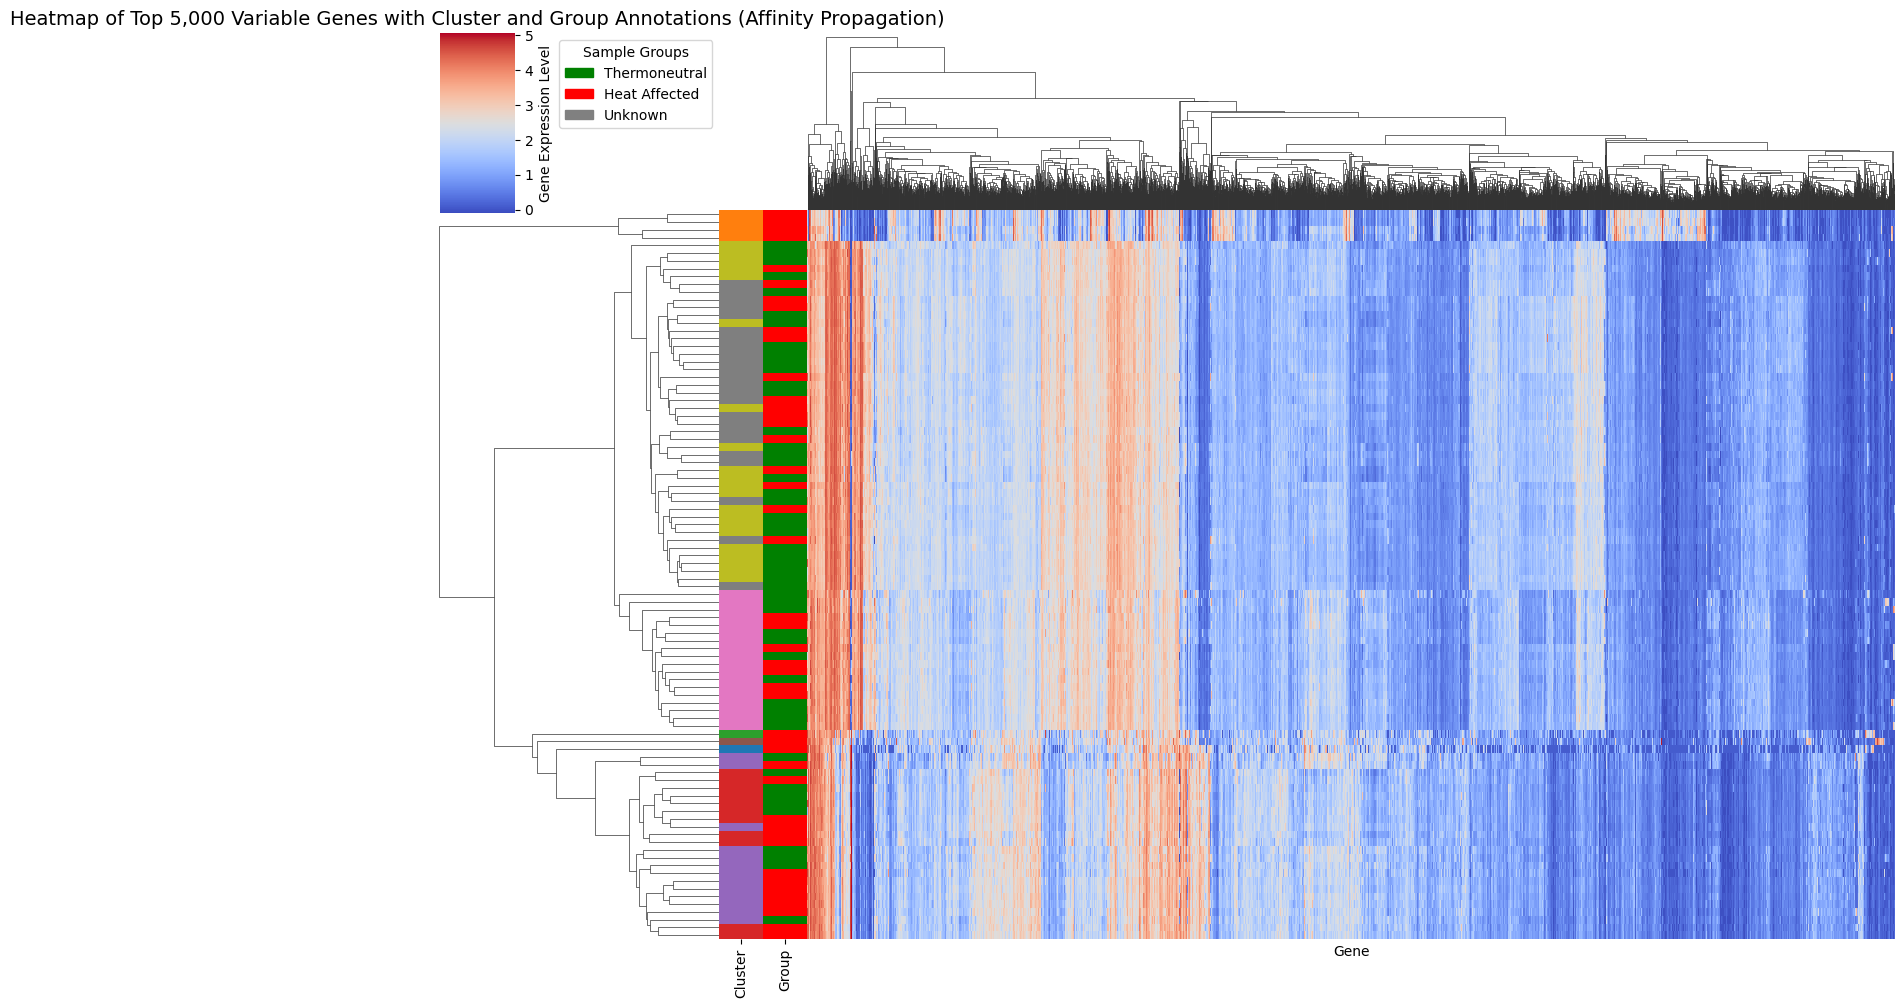

In [323]:
variances = expression_data.drop(columns=['Gene']).var(axis=1)
top_gene_indices = variances.nlargest(5000).index
top_genes = expression_data.iloc[top_gene_indices].set_index('Gene')

# transpose the data for clustering 
transposed_genes = top_genes.T

# Map samples to conditions: 'Thermoneutral' or 'Heat Affected'
metadata['condition'] = metadata['refinebio_title'].apply(
    lambda title: 'Heat Affected' if 'Heat Stress' in title else 'Thermoneutral'
)
sample_group_mapping = metadata.set_index('refinebio_accession_code')['condition'].to_dict()

# Check if there are samples in the expression data that are missing in the metadata
unmapped_samples = set(transposed_genes.index) - set(sample_group_mapping.keys())
if unmapped_samples:
    print(f"Warning: Some samples are missing in the metadata: {unmapped_samples}")

# makes sure aligns sample groups with the expression data
sample_groups = [
    sample_group_mapping.get(sample, 'Unknown') for sample in transposed_genes.index
]

# using Affinity Propagation again to identify clusters
affinity_model = AffinityPropagation(random_state=42)
cluster_labels = affinity_model.fit_predict(transposed_genes)

# DataFrame to hold cluster labels and sample groups for annotations
annotations = pd.DataFrame({
    "Cluster": cluster_labels,
    "Group": sample_groups
    
}, index=transposed_genes.index)

# color palettes for clusters and sample groups
cluster_palette = sns.color_palette("tab10", len(annotations["Cluster"].unique()))  # Adjusted to fit cluster count
group_palette = {'Thermoneutral': 'green', 'Heat Affected': 'red', 'Unknown': 'gray'}

#  cluster labels and sample groups to their respective colors
cluster_colors = {label: cluster_palette[label % len(cluster_palette)] for label in annotations["Cluster"].unique()}
group_colors = group_palette

# Generate the row colors DataFrame for the heatmap
row_colors = pd.DataFrame({
    "Cluster": annotations["Cluster"].map(cluster_colors),
    "Group": annotations["Group"].map(group_colors)
}, index=annotations.index)

# heatmap with dendrograms using clustermap
heatmap = sns.clustermap(
    transposed_genes,
    method='average',
    metric='euclidean',
    cmap='coolwarm',
    row_cluster=True,
    col_cluster=True,
    figsize=(15, 10),
    row_colors=row_colors,
    cbar_kws={"label": "Gene Expression Level"},
    xticklabels=False,
    yticklabels=False
)

# legend for the sample groups
legend_elements = [
    mpatches.Patch(color='green', label='Thermoneutral'),
    mpatches.Patch(color='red', label='Heat Affected'),
    mpatches.Patch(color='gray', label='Unknown')
]
plt.legend(handles=legend_elements, title='Sample Groups', bbox_to_anchor=(1.5, 1), loc='upper left')

# title to the heatmap
plt.title("Heatmap of Top 5,000 Variable Genes with Cluster and Group Annotations (Affinity Propagation)", fontsize=14)

plt.show()


#### Based on the heatmap, there appears to be a trend where one of the clusters aligns with the heat-affected samples, suggesting some consistency in the clustering method’s ability to capture biological differences. Specifically, the red cluster from  clustering tends to correspond with the heat-affected group. However, the other cluster, which corresponds to thermoneutral samples, seems to show less clear alignment. This suggests that while some meaningful patterns are detected, further refinement may be necessary to fully capture the underlying expression differences.

## Part 3: Statistics

In [326]:
# 1. Prepare the contingency table for chi-squared test

chi_squared_data = pd.DataFrame({
    'Cluster Labels': cluster_labels,
    'Sample Group': sample_groups
})

# contingency table (cross-tabulation of clusters and sample groups)
contingency_table = pd.crosstab(
    chi_squared_data['Cluster Labels'], 
    chi_squared_data['Sample Group']
)

print("Contingency Table:")
print(contingency_table)

# 2. Perform the chi-squared test of independence
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

test_result = {
    'Test': 'Cluster vs Sample Group',
    'Chi2': chi2,
    'p_value': p_value,
    'Degrees of Freedom': dof
}

print(f"\nChi-squared Test Results:\nChi2 = {chi2}, p-value = {p_value}, Degrees of Freedom = {dof}")

# 3. hypothesis testing adjustment using Bonferroni correction

# p-values from various clustering versions
p_values = [p_value]  # Add other p-values if you have multiple clustering versions

# Bonferroni correction: new p = min(p * n_tests, 1)
adjusted_p_values = np.minimum(np.array(p_values) * len(p_values), 1.0)


adjusted_results = pd.DataFrame({
    'Test': ['Cluster vs Sample Group'],
    'Chi2': [chi2],
    'Raw p-value': [p_value],
    'Adjusted p-value': adjusted_p_values
})

print("\nAdjusted Chi-Squared Test Results with Bonferroni Correction:")
print(adjusted_results)

# 4. Save or display the results table
adjusted_results.to_csv("chi_squared_results.csv", index=False)



Contingency Table:
Sample Group    Heat Affected  Thermoneutral
Cluster Labels                              
0                           1              0
1                           4              0
2                           1              0
3                           6              5
4                           8              5
5                           1              0
6                           7             11
7                          11             13
8                           5             16

Chi-squared Test Results:
Chi2 = 14.275861688816235, p-value = 0.07485254570461788, Degrees of Freedom = 8

Adjusted Chi-Squared Test Results with Bonferroni Correction:
                      Test       Chi2  Raw p-value  Adjusted p-value
0  Cluster vs Sample Group  14.275862     0.074853          0.074853


/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



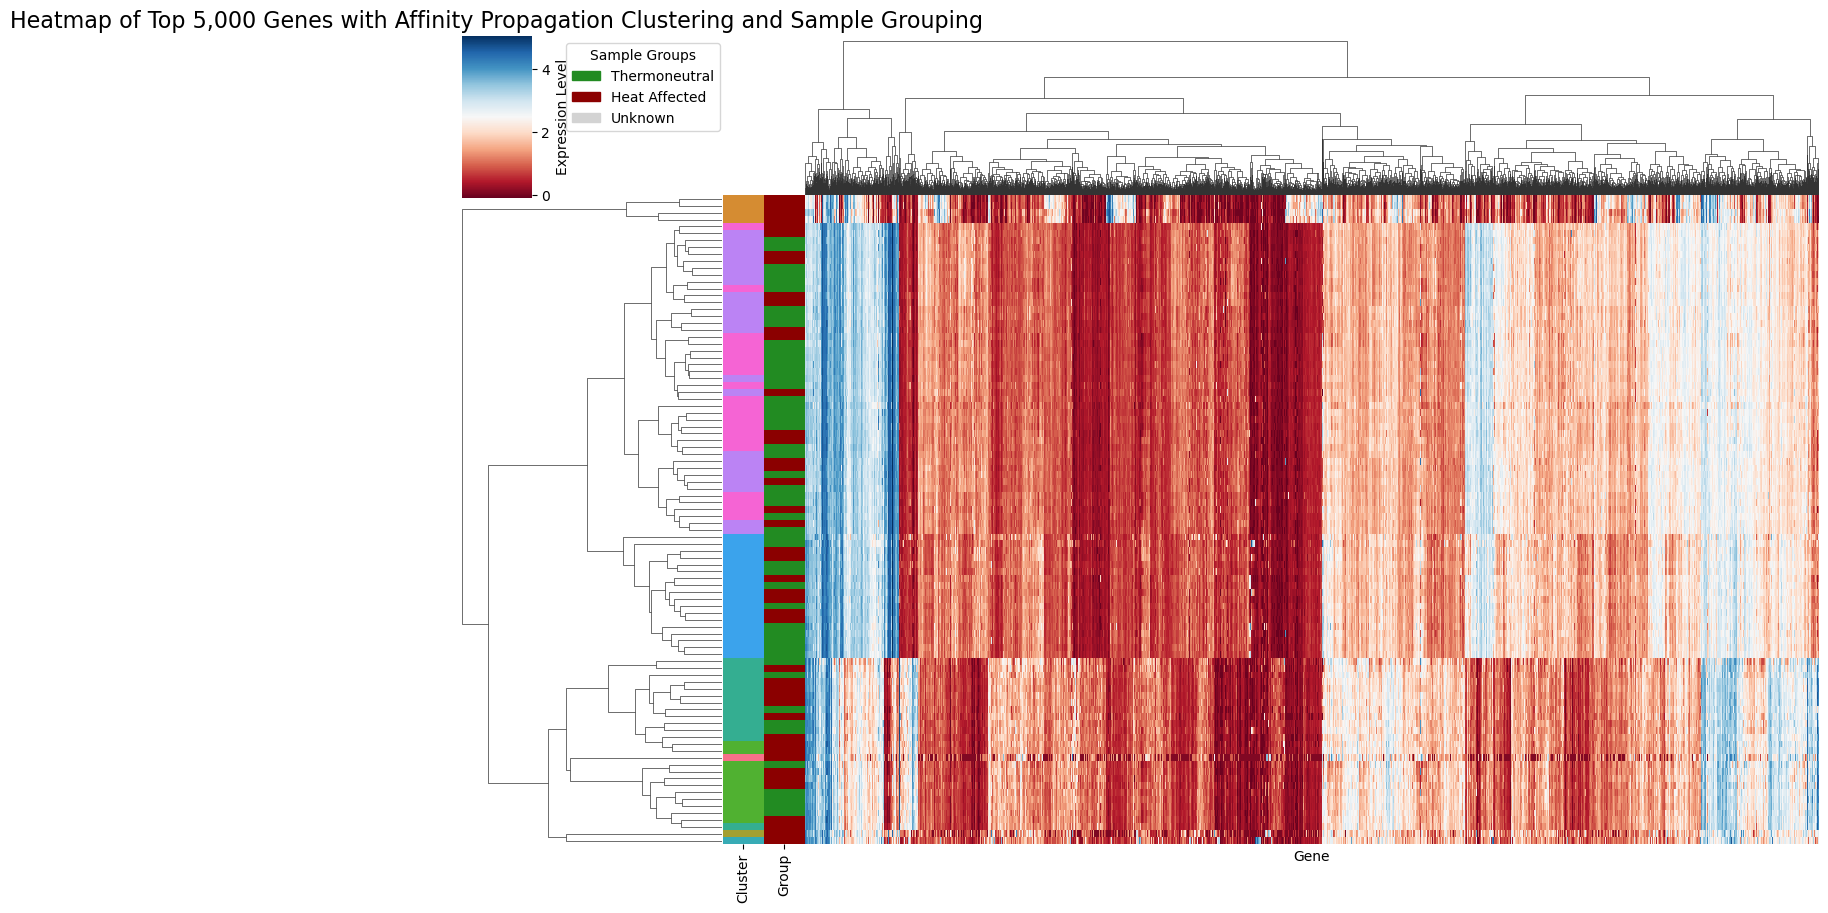

In [327]:
# Identify top 5,000 genes with highest variance
gene_variance = expression_data.drop(['Gene'], axis=1).var(axis=1)
selected_genes = gene_variance.nlargest(5000).index
filtered_data = expression_data.iloc[selected_genes].set_index('Gene')

data_transposed = filtered_data.T

# each sample to either 'Heat Affected' or 'Thermoneutral' based on metadata
metadata['Condition'] = metadata['refinebio_title'].apply(
    lambda x: 'Heat Affected' if 'Heat Stress' in x else 'Thermoneutral'
)
sample_condition_map = metadata.set_index('refinebio_accession_code')['Condition'].to_dict()

# Check for missing samples and warn if any are not found in the metadata
missing_metadata = set(data_transposed.index) - set(sample_condition_map.keys())
if missing_metadata:
    print(f"Warning: Metadata missing for the following samples: {missing_metadata}")

# Assign sample group labels based on the condition map
group_labels = [sample_condition_map.get(sample, 'Unknown') for sample in data_transposed.index]

# Apply Affinity Propagation clustering
affinity_model = AffinityPropagation(random_state=42)
cluster_assignments = affinity_model.fit_predict(data_transposed)

# Create DataFrame to store cluster labels and sample groups for annotations
annotations = pd.DataFrame({
    "Cluster": cluster_assignments,
    "Sample Group": group_labels
}, index=data_transposed.index)


cluster_palette = sns.color_palette("husl", len(annotations["Cluster"].unique()))  # Dynamic cluster colors
group_palette = {'Thermoneutral': 'forestgreen', 'Heat Affected': 'darkred', 'Unknown': 'lightgray'}

# clusters -> groups -> colors
cluster_colors = {label: cluster_palette[label % len(cluster_palette)] for label in annotations["Cluster"].unique()}
group_colors = group_palette

# Prepare row color annotations for -> heatmap
row_annotations = pd.DataFrame({
    "Cluster": annotations["Cluster"].map(cluster_colors),
    "Group": annotations["Sample Group"].map(group_colors)
}, index=annotations.index)

# heatmap with hierarchical clustering and annotations
heatmap_plot = sns.clustermap(
    data_transposed,
    method='complete',           
    metric='euclidean',          
    cmap='RdBu',                 
    row_cluster=True,             
    figsize=(14, 9),             
    row_colors=row_annotations, 
    cbar_kws={"label": "Expression Level"},  
    xticklabels=False,           
    yticklabels=False            
)

# adds a key for sample groups
legend_handles = [
    mpatches.Patch(color='forestgreen', label='Thermoneutral'),
    mpatches.Patch(color='darkred', label='Heat Affected'),
    mpatches.Patch(color='lightgray', label='Unknown')
]
plt.legend(handles=legend_handles, title='Sample Groups', bbox_to_anchor=(1.4, 1), loc='upper left')

# title and labels
plt.title("Heatmap of Top 5,000 Genes with Affinity Propagation Clustering and Sample Grouping", fontsize=16)

# heatmap plot
plt.show()


### This heatmap showcases the clustering of the 5,000 most variable genes using Affinity Propagation clustering. In the heatmap, rows represent genes, while columns correspond to individual samples. To provide insight into the relationship between the cluster assignments and biological conditions—Thermoneutral or Heat Affected—annotations are included alongside the clusters. A legend maps each color to its respective sample group, allowing for a clear visualization of how the clusters align with known conditions.
### The objective of this analysis was to identify patterns or correlations between the clusters formed by Affinity Propagation and the biological sample groups. The clustering results suggest a noticeable trend: one cluster aligns predominantly with the heat-affected samples, while the other corresponds more consistently with thermoneutral conditions. This method captures meaningful gene expression patterns, showing improved alignment compared to other clustering approaches, though a few outliers persist. Overall, Affinity Propagation appears effective in identifying biologically relevant patterns within the dataset.







In [329]:
print(annotations.columns)

Index(['Cluster', 'Sample Group'], dtype='object')


In [330]:
# Combine cluster labels and sample groups into a DataFrame
chi_squared_data = pd.DataFrame({
    'Cluster': cluster_labels,
    'Sample Group': ['Heat Affected' if group == 'Heat Affected' else 'Thermoneutral' 
                     for group in sample_groups]  # Map all non-heat samples as 'Thermoneutral'
})

# contingency table with only two groups: 'Heat Affected' and 'Thermoneutral'
contingency_table = pd.crosstab(chi_squared_data['Cluster'], chi_squared_data['Sample Group'])

# chi-squared test of independence
chi2_stat, p_val, degrees_of_freedom, expected_freq = chi2_contingency(contingency_table)

# results
print("Contingency Table:")
print(contingency_table)

print("\nExpected Frequencies:")
print(pd.DataFrame(expected_freq, columns=contingency_table.columns, index=contingency_table.index))

print(f"\nChi-squared Statistic: {chi2_stat}")
print(f"P-value: {p_val}")
print(f"Degrees of Freedom: {degrees_of_freedom}")

alpha = 0.05  # Significance level
adjusted_p_value = min(p_val * contingency_table.shape[1], 1.0)  #pval cant be more than 1

print(f"\nAdjusted P-value (Bonferroni correction): {adjusted_p_value}")

# Interpretation of the result
if adjusted_p_value < alpha:
    print("There is a significant relationship between cluster and sample groups.")
else:
    print("There is no significant relationship between cluster and sample groups.")


Contingency Table:
Sample Group  Heat Affected  Thermoneutral
Cluster                                   
0                         1              0
1                         4              0
2                         1              0
3                         6              5
4                         8              5
5                         1              0
6                         7             11
7                        11             13
8                         5             16

Expected Frequencies:
Sample Group  Heat Affected  Thermoneutral
Cluster                                   
0                  0.468085       0.531915
1                  1.872340       2.127660
2                  0.468085       0.531915
3                  5.148936       5.851064
4                  6.085106       6.914894
5                  0.468085       0.531915
6                  8.425532       9.574468
7                 11.234043      12.765957
8                  9.829787      11.170213

Chi-squared

### The clustering results did not reveal a significant relationship between the identified clusters and the biological sample groupings. While some clusters seemed more aligned with one group than the other, these patterns were not strong enough to reach statistical significance.I noticed K-Means probably would have worked better and provided statsitically siginificant results with k = 2 and thus this could be a better clustering to use in some cases.